In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score as acc
from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings('ignore')

# データの読込
train = pd.read_csv("./data/train_data.csv")
test = pd.read_csv("./data/test_data.csv")
weapon_info = pd.read_csv("./data/statink-weapon2.csv")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [55]:
mlb_subweapon = MultiLabelBinarizer()
mlb_subweapon.fit([set(weapon_info.fillna("none").subweapon)])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [60]:
weapon_info.keys()

Index(['category1', 'category2', 'key', 'subweapon', 'special', 'mainweapon',
       'reskin', 'splatnet', '[de-DE]', '[en-GB]', '[en-US]', '[es-ES]',
       '[es-MX]', '[fr-CA]', '[fr-FR]', '[it-IT]', '[ja-JP]', '[nl-NL]',
       '[ru-RU]', '[zh-CN]', '[zh-TW]'],
      dtype='object')

In [62]:
change_weapon = {
    "heroblaster_replica":  "hotblaster",
    "herobrush_replica": "hokusai", 
    "herocharger_replica":  "splatcharger",
    "heromaneuver_replica":"maneuver",
    "heroroller_replica":"splatroller",
    "heroshelter_replica":"parashelter",
    "heroshooter_replica":"sshooter",
    "heroslosher_replica":"bucketslosher",
    "herospinner_replica":"barrelspinner",
    "octoshooter_replica":"sshooter"
                }

train = train.replace(change_weapon)
test = test.replace(change_weapon)

mlb = MultiLabelBinarizer()
mlb.fit([set(weapon_info.fillna("none").key)])
mlb_subweapon = MultiLabelBinarizer()
mlb_subweapon.fit([set(weapon_info.fillna("none").subweapon)])
mlb_mainweapon = MultiLabelBinarizer()
mlb_mainweapon.fit([set(weapon_info.fillna("none").mainweapon)])
mlb_special = MultiLabelBinarizer()
mlb_special.fit([set(weapon_info.fillna("none").special)])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [64]:
mlb_subweapon.classes_

array(['curlingbomb', 'jumpbeacon', 'kyubanbomb', 'pointsensor',
       'poisonmist', 'quickbomb', 'robotbomb', 'splashbomb',
       'splashshield', 'sprinkler', 'tansanbomb', 'torpedo', 'trap'],
      dtype=object)

In [4]:
len(mlb.classes_)

139

In [5]:
train.head(3)

,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,...,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y
0,1,2019-10-15T20:00:00+00:00,5.0.1,regular,standard,nawabari,sumeshi,sshooter_becchu,NaN,139,...,hokusai_becchu,NaN,26.0,splatcharger,NaN,68.0,sharp_neo,NaN,31.0,1
1,2,2019-12-14T04:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,parashelter_sorella,NaN,198,...,squiclean_b,NaN,118.0,campingshelter,NaN,168.0,sputtery_clear,NaN,151.0,0
2,3,2019-12-25T14:00:00+00:00,5.0.1,gachi,standard,hoko,ama,nzap89,a-,114,...,nzap85,a+,163.0,prime_becchu,a-,160.0,dualsweeper_custom,a,126.0,0


In [6]:
print("all\t",len(train), len(test))
print("regular\t", len(train[train["lobby-mode"]=="regular"]), len(test[test["lobby-mode"]=="regular"]))
print("gachi\t", len(train[train["lobby-mode"]=="gachi"]), len(test[test["lobby-mode"]=="gachi"]))
print(train["lobby-mode"].unique())

all	 66125 28340
regular	 14444 6272
gachi	 51681 22068
['regular' 'gachi']


In [7]:
train.y.sum()

34696

In [81]:
#武器名を武器の情報に変換し、要素を追加したい。
A = ['A1-weapon', 'A2-weapon', 'A3-weapon', 'A4-weapon']
for idx in train.index:
    for i in A:
        weapon_info[weapon_info["key"]==train[i].iloc[idx]]

In [65]:
def make_feature(df_train, df_test):
    train_num = len(df_train)
    df = pd.concat([df_train, df_test])
    
    
    #print(len(df))
    cat_cols = ["lobby-mode", "mode", "stage"]
    for c in cat_cols:
        vv, obj = pd.factorize(df[c])
        df[c] = vv
    #print(len(df))
    
    A = ['A1-weapon', 'A2-weapon', 'A3-weapon', 'A4-weapon']
    B = ['B1-weapon', 'B2-weapon', 'B3-weapon', 'B4-weapon']

    wa = mlb.transform(df[A].fillna("none")[A].values)
    wb = mlb.transform(df[B].fillna("none")[B].values)
    
    swa = mlb_subweapon.transform(df[A])
    swb
    
    mwa
    mwb
    
    sa
    sb
    
    for i in range(wa.shape[1]):
        df["A-" + mlb.classes_[i]] = wa[:, i]
        df["B-" + mlb.classes_[i]] = wb[:, i]
    s = ["A", "B"]
    p = ["1", "2", "3", "4"]
    for i in s:
        for j in p:
            df[i+j+"-level"] = df[i+j+"-level"]//10
            #df[i+j+"-level"] = df[i+j+"-level"].clip(0,30)

        
    return df[:train_num], df[train_num:]

In [9]:
#tr, te = make_feature(train, test)
#tr, te = make_feature(train[train['lobby-mode']=='regular'], test[test['lobby-mode']=='regular'])
tr, te = make_feature(train[train['lobby-mode']=='gachi'], test[test['lobby-mode']=='gachi'])

feature_cols = [
     'lobby-mode', 'mode', 'stage',
]
feature_cols.extend(["A-" + i for i in mlb.classes_])
feature_cols.extend(["B-" + i for i in mlb.classes_])
print(tr.shape)

(51681, 310)


In [10]:
tr.head(3)

,A1-level,A1-rank,A1-weapon,A2-level,A2-rank,A2-weapon,A3-level,A3-rank,A3-weapon,A4-level,...,A-sshooter_becchu,B-sshooter_becchu,A-sshooter_collabo,B-sshooter_collabo,A-variableroller,B-variableroller,A-variableroller_foil,B-variableroller_foil,A-wakaba,B-wakaba
2,11,a-,nzap89,6.0,a,quadhopper_black,22.0,a,prime_becchu,10.0,...,0,0,0,0,0,0,0,0,0,0
4,29,x,bold_7,9.0,x,hissen_hue,9.0,x,h3reelgun_d,13.0,...,0,0,0,0,0,0,0,0,0,1
5,19,s,nzap85,11.0,s,dualsweeper_custom,27.0,s,prime_becchu,5.0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#def cv_score(clf,X,y,n_splits=5,kf=StratifiedKFold(n_splits=5))->float:
    
kf=KFold(n_splits=5, random_state = 0)
score = 0
counter = 1
for train_index, valid_index in kf.split(tr, tr.y):
        train_X,valid_X = tr.loc[train_index,:].copy(),tr.loc[valid_index,:].copy()
        train_y,valid_y = tr.y.iloc[train_index],tr.y.iloc[valid_index]
        
        train_X, valid_X = make_feature(train_X, valid_X)
        
        
        clf = lgb.LGBMClassifier()
        clf.fit(train_X[feature_cols],train_y)
        preds = clf.predict(valid_X[feature_cols])
        acc_score = acc(valid_y,preds)
        print(f"fold{counter} score is :{acc_score}")
        score += acc_score
        counter += 1
print("average : ",round(score/5,5))

fold1 score is :0.5036277449937119
fold2 score is :0.5055147058823529
fold3 score is :0.5071594427244582
fold4 score is :0.506578947368421
fold5 score is :0.5143188854489165
average :  0.50744


In [12]:
tr, te = make_feature(train, test)
print(te.iloc[0])
#for i in tr.columns:
    #print(i)

A1-level                            17
A1-rank                              x
A1-weapon                prime_collabo
A2-level                            13
A2-rank                              x
                             ...      
B-variableroller                     0
A-variableroller_foil                0
B-variableroller_foil                0
A-wakaba                             0
B-wakaba                             0
Name: 0, Length: 310, dtype: object


In [29]:
tr, te = make_feature(train, test)
tr_0 = tr[tr["lobby-mode"]==0]
tr_1 = tr[tr["lobby-mode"]==1]
clf_0 = lgb.LGBMClassifier().fit(tr_0[feature_cols].fillna(0),tr_0["y"].fillna(0))
clf_1 = lgb.LGBMClassifier().fit(tr_1[feature_cols].fillna(0),tr_1["y"].fillna(0))
pred_test = []
for idx in range(len(te)):
    pred = 0
    data = te.iloc[idx][feature_cols]
    if data["lobby-mode"]==0:
        pred=clf_0.predict([data])[0]
    elif data["lobby-mode"]==1:
        pred=clf_1.predict([data])[0]
    pred_test.append(pred)
pd.DataFrame({"id": range(len(pred_test)), "y": pred_test }).to_csv("submission.csv", index=False)

In [30]:
pred_test=np.array(pred_test)

In [31]:
pred_test[pred_test == 1].sum()

18637.0

In [32]:
pred_test[pred_test == 0].sum()

0.0

In [33]:
# importanceを表示する
#importance = pd.DataFrame(clf.feature_importances_,  index=feature_cols, importance = "gain")
importance = pd.DataFrame(clf.booster_.feature_importance(importance_type='gain'), index=feature_cols, columns = ["f"])

importance.sort_values("f", ascending = False).head(10)

,f
stage,2220.498223
mode,836.989980
B-splatroller,249.123589
A-splatroller,203.655931
B-nzap85,201.465290
B-dualsweeper_custom,195.053128
A-prime_becchu,193.919700
A-nzap85,164.670461
B-prime_becchu,150.355181
A-wakaba,149.944809


In [34]:
mlb.classes_

array(['52gal', '52gal_becchu', '52gal_deco', '96gal', '96gal_deco',
       'bamboo14mk1', 'bamboo14mk2', 'bamboo14mk3', 'barrelspinner',
       'barrelspinner_deco', 'barrelspinner_remix', 'bold', 'bold_7',
       'bold_neo', 'bottlegeyser', 'bottlegeyser_foil', 'bucketslosher',
       'bucketslosher_deco', 'bucketslosher_soda', 'campingshelter',
       'campingshelter_camo', 'campingshelter_sorella', 'carbon',
       'carbon_deco', 'clashblaster', 'clashblaster_neo', 'dualsweeper',
       'dualsweeper_custom', 'dynamo', 'dynamo_becchu', 'dynamo_tesla',
       'explosher', 'explosher_custom', 'furo', 'furo_deco', 'h3reelgun',
       'h3reelgun_cherry', 'h3reelgun_d', 'heroblaster_replica',
       'herobrush_replica', 'herocharger_replica', 'heromaneuver_replica',
       'heroroller_replica', 'heroshelter_replica', 'heroshooter_replica',
       'heroslosher_replica', 'herospinner_replica', 'hissen',
       'hissen_hue', 'hokusai', 'hokusai_becchu', 'hokusai_hue',
       'hotblaster', '

In [35]:
s = ["A", "B"]
p = ["1", "2", "3", "4"]
d = []
for i in s:
    for j in p:
        d .extend(list(train[i+j+"-level"].values))

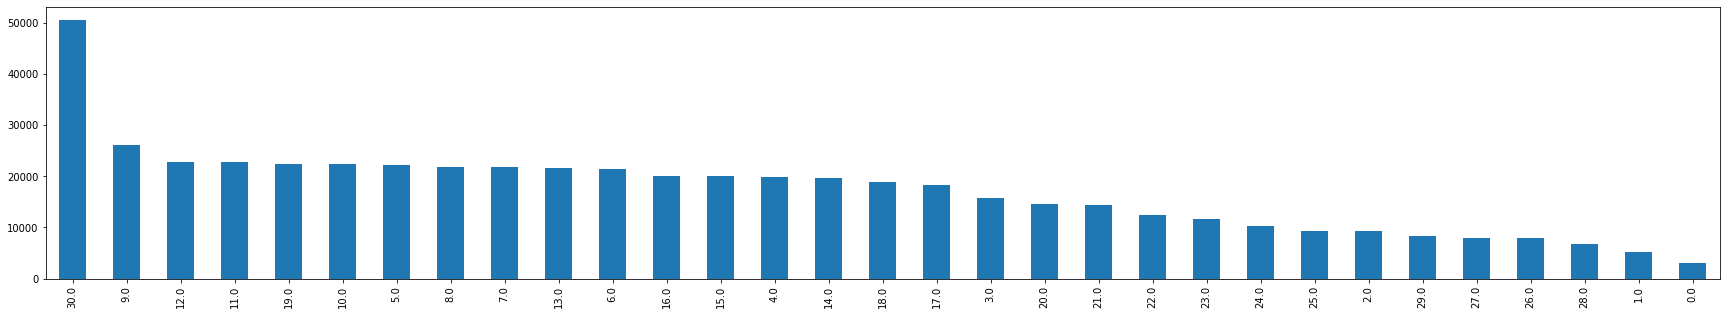

In [36]:
plt.figure(figsize = (30,5))
c = pd.DataFrame(d, columns = ["level"])
c.level = c.level//10
c.level.clip(0,30).value_counts().plot(kind = "bar")

In [37]:
c.level.max()

93.0